# Differentiable Particle Filter with Soft Resampling

This notebook shows how `SoftResampler` adds an extra gradient path
through the particle filter compared to standard `MultinomialResampler`.

In [1]:
import sys
sys.path.append("..")

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

from dpf import SMC, State
from dpf.observation.linear import LinearObservationModel
from dpf.transition import RandomWalkModel
from dpf.proposal.bootstrap import BootstrapProposal
from dpf.resampling.criterion import NeffCriterion
from dpf.resampling.differentiable.soft_resample import SoftResampler

tfd = tfp.distributions
np.random.seed(42)
tf.random.set_seed(42)

T, batch_size, n_particles = 100, 4, 500
F = tf.eye(1, dtype=tf.float64)
H = tf.eye(1, dtype=tf.float64)

## 1. Synthetic Data

$$x_t = x_{t-1} + w_t, \quad y_t = x_t + v_t, \quad w_t \sim \mathcal{N}(0, 0.25), \; v_t \sim \mathcal{N}(0, 0.25)$$

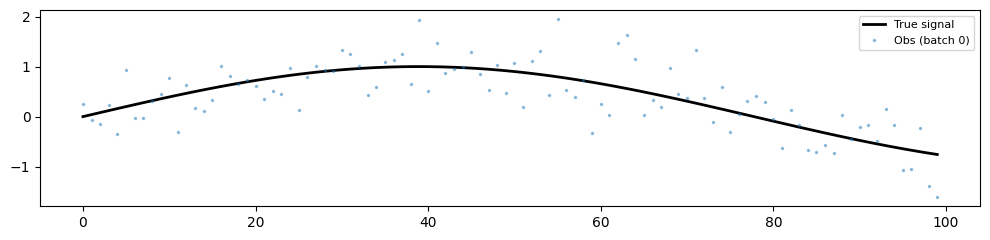

In [2]:
true_signal = np.sin(np.linspace(0., 4., T))
observations_np = true_signal[:, None] + np.random.normal(0., 0.5, (T, batch_size))
obs_tf = tf.constant(observations_np[:, :, None], dtype=tf.float64)  # [T, batch, 1]

plt.figure(figsize=(10, 2.5))
plt.plot(true_signal, 'k-', lw=2, label='True signal')
plt.plot(observations_np[:, 0], '.', alpha=0.4, ms=3, label='Obs (batch 0)')
plt.legend(fontsize=8); plt.tight_layout(); plt.show()

## 2. Run Filter with Soft Resampling

In [3]:
trans_noise = tfd.MultivariateNormalTriL(
    loc=tf.zeros([1], dtype=tf.float64),
    scale_tril=tf.constant([[0.5]], dtype=tf.float64))
obs_noise = tfd.MultivariateNormalTriL(
    loc=tf.zeros([1], dtype=tf.float64),
    scale_tril=tf.constant([[0.5]], dtype=tf.float64))

smc_soft = SMC(
    observation_model=LinearObservationModel(H, obs_noise),
    transition_model=RandomWalkModel(F, trans_noise),
    proposal_model=BootstrapProposal(RandomWalkModel(F, trans_noise)),
    resampling_criterion=NeffCriterion(threshold_ratio=0.5),
    resampling_method=SoftResampler(alpha=0.5),
)

init_state = State(
    particles=tf.constant(np.random.randn(batch_size, n_particles, 1), dtype=tf.float64),
    log_weights=tf.fill([batch_size, n_particles],
                        -tf.math.log(tf.cast(n_particles, tf.float64))))

final_state, series = smc_soft(init_state, obs_tf, return_series=True)
for b in range(batch_size):
    print(f'Batch {b} log-likelihood: {final_state.log_likelihoods[b].numpy():.2f}')

Batch 0 log-likelihood: -97.13
Batch 1 log-likelihood: -101.02
Batch 2 log-likelihood: -105.49
Batch 3 log-likelihood: -101.47


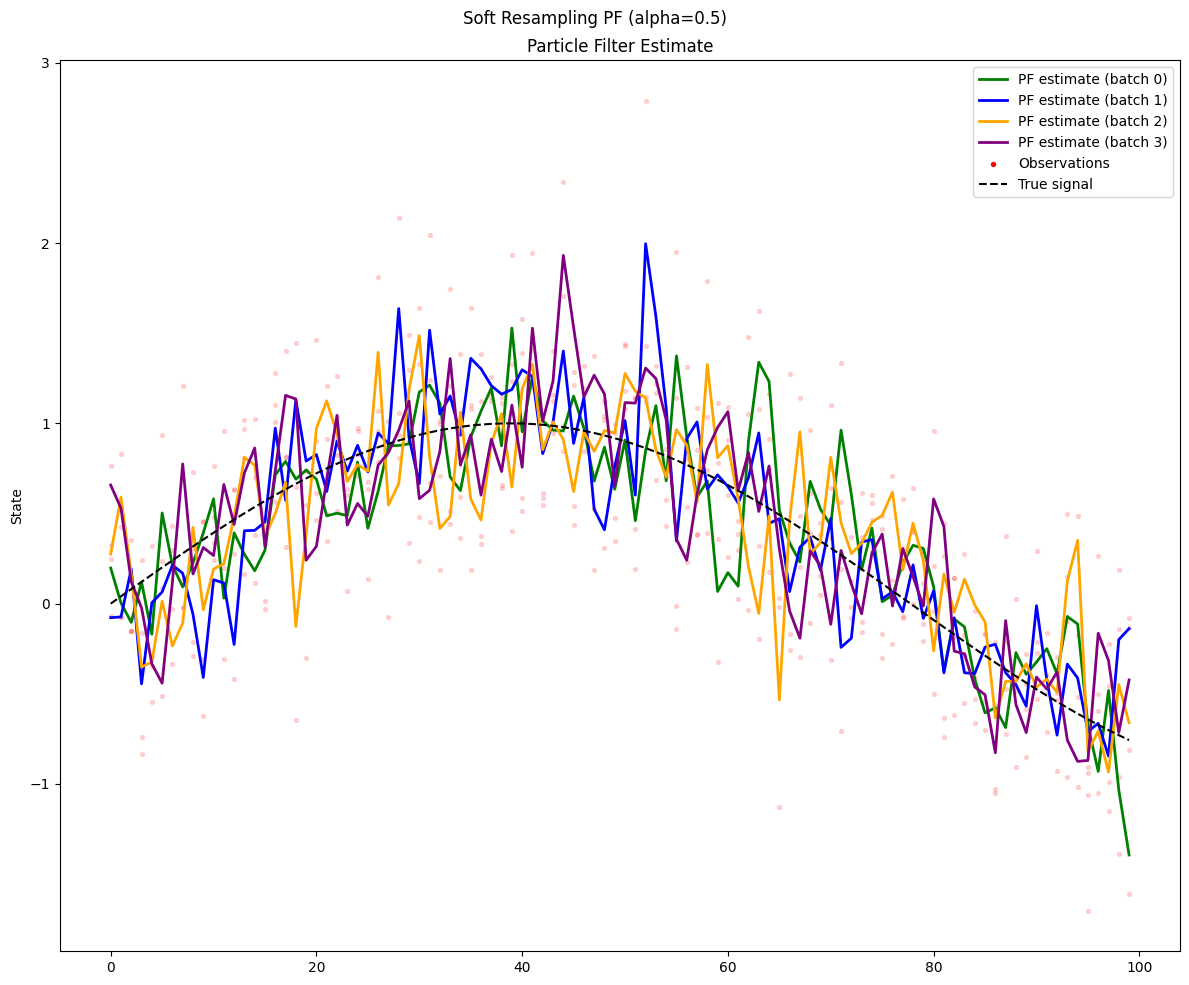

In [4]:
# Compute weighted mean estimate per batch
all_particles = series['particles'][:, :, :, 0].numpy()   # [T, batch, N]
all_weights = tf.nn.softmax(series['log_weights'], axis=-1).numpy()  # [T, batch, N]
filter_mean = np.sum(all_weights * all_particles, axis=2)  # [T, batch]

t = np.arange(T)
colors = ['green', 'blue', 'orange', 'purple']

fig, axes = plt.subplots(1, 1, figsize=(12, 10), sharex=True)

# Panel 1: Filtering result
for b in range(batch_size):
    axes.scatter(t, observations_np[:, b], c='red', s=8, alpha=0.15)
    axes.plot(t, filter_mean[:, b], color=colors[b], lw=2, label=f'PF estimate (batch {b})')
axes.scatter([], [], c='red', s=8, label='Observations')
axes.plot(t, true_signal, 'k--', lw=1.5, label='True signal')
axes.legend(loc='upper right')
axes.set_ylabel('State')
axes.set_title('Particle Filter Estimate')

fig.suptitle('Soft Resampling PF (alpha=0.5)'); plt.tight_layout(); plt.show()

## 3. Parameter Recovery via Gradient Descent

Start from a wrong observation noise scale ($\sigma_y = 1.0$) and use Adam
to recover the true value ($\sigma_y = 0.5$).

In [5]:
def build_and_run(theta_var, resampler, criterion, is_obs_param=True):
    """Build SMC with one trainable parameter and run it."""
    if is_obs_param:
        obs_n = tfd.MultivariateNormalTriL(
            loc=tf.zeros([1], dtype=tf.float64),
            scale_tril=tf.exp(theta_var))
        trans_n = tfd.MultivariateNormalTriL(
            loc=tf.zeros([1], dtype=tf.float64),
            scale_tril=tf.constant([[0.5]], dtype=tf.float64))
    else:
        obs_n = tfd.MultivariateNormalTriL(
            loc=tf.zeros([1], dtype=tf.float64),
            scale_tril=tf.constant([[0.5]], dtype=tf.float64))
        trans_n = tfd.MultivariateNormalTriL(
            loc=tf.zeros([1], dtype=tf.float64),
            scale_tril=tf.exp(theta_var))
    tm = RandomWalkModel(F, trans_n)
    smc = SMC(
        observation_model=LinearObservationModel(H, obs_n),
        transition_model=tm,
        proposal_model=BootstrapProposal(tm),
        resampling_criterion=criterion,
        resampling_method=resampler)
    return smc(init_state, obs_tf)

Iter 10 | loss=111.1 | sigma_y=0.6129 (true=0.5)
Iter 20 | loss=97.7 | sigma_y=0.4022 (true=0.5)
Iter 30 | loss=96.3 | sigma_y=0.3012 (true=0.5)
Iter 40 | loss=97.3 | sigma_y=0.2592 (true=0.5)
Iter 50 | loss=97.4 | sigma_y=0.2494 (true=0.5)
Iter 60 | loss=97.6 | sigma_y=0.2564 (true=0.5)
Iter 70 | loss=96.9 | sigma_y=0.2682 (true=0.5)


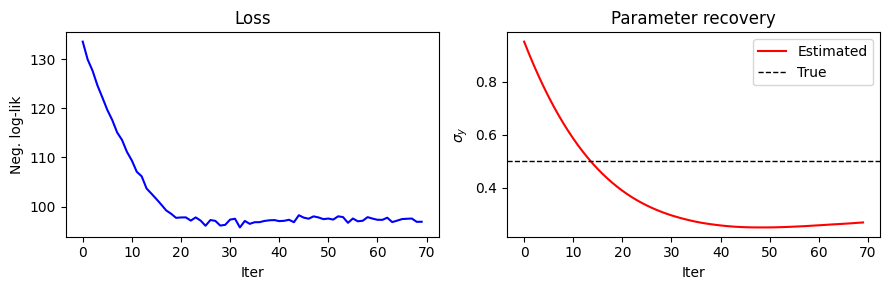

In [6]:
theta = tf.Variable(tf.constant([[0.0]], dtype=tf.float64))  # log(1.0) = 0
optimizer = tf.optimizers.Adam(learning_rate=0.05)
losses, scales = [], []

for i in range(70):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(
            build_and_run(theta, SoftResampler(0.5), NeffCriterion(0.5), True).log_likelihoods)
    g = tape.gradient(loss, [theta])
    if g[0] is not None:
        optimizer.apply_gradients(zip(g, [theta]))
    losses.append(loss.numpy())
    scales.append(tf.exp(theta).numpy().item())
    if (i+1) % 10 == 0:
        print(f'Iter {i+1:2d} | loss={loss.numpy():.1f} | sigma_y={scales[-1]:.4f} (true=0.5)')

fig, (a1, a2) = plt.subplots(1, 2, figsize=(9, 3))
a1.plot(losses, 'b-'); a1.set(xlabel='Iter', ylabel='Neg. log-lik', title='Loss')
a2.plot(scales, 'r-', label='Estimated')
a2.axhline(0.5, color='k', ls='--', lw=1, label='True')
a2.set(xlabel='Iter', ylabel='$\\sigma_y$', title='Parameter recovery')
a2.legend(); plt.tight_layout(); plt.show()

### 4. Using the optimal_theta to calcualte the likelihood

In [9]:
optimal_theta = theta.numpy()

In [12]:
trans_noise = tfd.MultivariateNormalTriL(
    loc=tf.zeros([1], dtype=tf.float64),
    scale_tril=tf.constant([[0.5]], dtype=tf.float64))
obs_noise = tfd.MultivariateNormalTriL(
    loc=tf.zeros([1], dtype=tf.float64),
    scale_tril=tf.constant(tf.exp(optimal_theta), dtype=tf.float64))

smc_soft = SMC(
    observation_model=LinearObservationModel(H, obs_noise),
    transition_model=RandomWalkModel(F, trans_noise),
    proposal_model=BootstrapProposal(RandomWalkModel(F, trans_noise)),
    resampling_criterion=NeffCriterion(threshold_ratio=0.5),
    resampling_method=SoftResampler(alpha=0.5),
)

init_state = State(
    particles=tf.constant(np.random.randn(batch_size, n_particles, 1), dtype=tf.float64),
    log_weights=tf.fill([batch_size, n_particles],
                        -tf.math.log(tf.cast(n_particles, tf.float64))))

final_state, series = smc_soft(init_state, obs_tf, return_series=True)
for b in range(batch_size):
    print(f'Batch {b} log-likelihood: {final_state.log_likelihoods[b].numpy():.2f}')

Batch 0 log-likelihood: -86.84
Batch 1 log-likelihood: -99.54
Batch 2 log-likelihood: -104.50
Batch 3 log-likelihood: -95.15
